In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, GlobalAveragePooling2D, Reshape, multiply
from keras.models import Model

import numpy as np
import tensorflow as tf
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

width = 32
height = 32

#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="./dogsandcats",target_size=(32,32))
tdata = ImageDataGenerator()
testdata = tdata.flow_from_directory(directory="./dogsandcats",target_size=(32,32))


Found 84 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/LearningSpoons\ CV

/content/drive/MyDrive/LearningSpoons CV


In [ ]:
def Residual_Block(x, n_ch):
    skip_connection = x # 초기의 x
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_ch, kernel_size=(3,3), strides=1, padding='same')(x) # 크기 안변하게 하는 패딩이 케라스에선 same
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_ch, kernel_size=(3,3), strides=1, padding='same')(x)
    x = add([x, skip_connection])
    
    return x


In [ ]:
def SEmodule(pre_layer, ch, r):
    x = GlobalAveragePooling2D()(pre_layer)

    x = Dense(int(ch/r), activation='relu')(x)
    
    x = Dense(ch, activation='sigmoid')(x)

    x = Reshape((1, 1, ch))(x)

    x = multiply([pre_layer,x])
    
    return x

In [ ]:
def Residual_Block_50(x, filters):
    f1, f2 = filters
    x_skip = x # 초기의 x
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    x = Conv2D(f1, kernel_size=(1,1), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f1, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size=(1,1), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_skip = Conv2D(f2, kernel_size=(1,1),strides=(1,1),padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)    

    x = add([x, x_skip])
    x = Activation('relu')(x)    
    return x

In [ ]:

inputs = Input(shape=(32,32,3))
x = Conv2D(64, kernel_size=7, strides=2, padding='valid')(inputs) # 크기가 변해야 하므로 (반으로 줄어야 하므로) 일단 valid
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
x = Residual_Block_50(x, filters=(64,256)) 
x = Residual_Block_50(x, filters=(64,256)) 
x = Residual_Block_50(x, filters=(64,256)) 
x = Residual_Block_50(x, filters =(128,512)) 
x = Residual_Block_50(x, filters =(128,512)) 
x = Residual_Block_50(x, filters =(128,512)) 
x = Residual_Block_50(x, filters =(128,512)) 
x = Residual_Block_50(x, filters =(256,1024)) 
x = Residual_Block_50(x, filters =(256,1024)) 
x = Residual_Block_50(x, filters =(256,1024)) 
x = Residual_Block_50(x, filters =(256,1024)) 
x = Residual_Block_50(x, filters =(256,1024)) 
x = Residual_Block_50(x, filters =(256,1024)) 
x = Residual_Block_50(x, filters =(512,2048)) 
x = Residual_Block_50(x, filters =(512,2048)) 
x = Residual_Block_50(x, filters =(512,2048)) 

x = GlobalAveragePooling2D()(x) # 빈 괄호는 option 없는 것

outputs = Dense(2, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 7, 7, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:

#from keras.callbacks import EarlyStopping


history = model.fit_generator(traindata, 
                             validation_data = testdata,
                              epochs = 10,
                              callbacks = [
                                           tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience = 3),
                                           tf.keras.callbacks.ModelCheckpoint(filepath='./',save_weights_only=True,monitor='val_accuracy',save_best_only=True)
                                           ]
                              )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
3/3 [==============================] - 33s 2s/step - loss: 0.8032 - accuracy: 0.4640 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 1s 323ms/step - loss: 0.7518 - accuracy: 0.5204 - val_loss: 0.6933 - val_accuracy: 0.5238
Epoch 3/10
3/3 [==============================] - 1s 307ms/step - loss: 0.7348 - accuracy: 0.5333 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 315ms/step - loss: 0.8661 - accuracy: 0.4940 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 336ms/step - loss: 1.5431 - accuracy: 0.3979 - val_loss: 0.6950 - val_accuracy: 0.5000


In [ ]:
pwd

'/content/drive/My Drive/LearningSpoons CV'

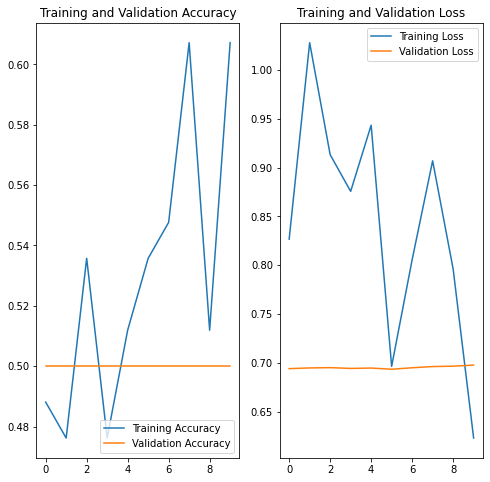

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

https://www.tensorflow.org/overview